# Détection de thématiques avec LDA (Latend Dirichlet Allocation).

Dans ce TP, nous allons mettre application une technique assez simple permettant de détecter les thématiques abordées dans un corpus de textes. Cette technique est largement utilisée pour l'exploration des données textuelles, comme une phase d'analyse des données ; mais également à des fins prédicitives, pour le clustering des texes (commentaires, news, etc.).

In [48]:
!python3 -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 43.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


In [49]:
!pip install pyLDAvis==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pytest from https://files.pythonhosted.org/packages/33/b2/741130cbcf2bbfa852ed95a60dc311c9e232c7ed25bac3d9b8880a8df4ae/pytest-7.4.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 44.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for pluggy<2.0,>=0.12 from https://files.pythonhosted.org/packages/51/32/4a79112b8b87b21450b066e102d6608907f4c885ed7b04c3fdb085d4d6ae/pluggy-1.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 29.2 MB/s eta 0:00:00
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97721 sha256=5103dac476455ceb082fcd1866870f5916104d0de131b9d166e7833061844b33
  Stored in directory: /Users/dataworkshop/Library/Caches/pip/wheels/d2/88/c8/ab7982c442ee90375cb2233818b

In [51]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy
import fr_core_news_md
import gensim
import pyLDAvis.gensim
from string import punctuation
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from pylab import rcParams
from collections import Counter
from wordcloud import WordCloud
import warnings

In [52]:
warnings.filterwarnings('ignore')

## Chargement des données.

Les données que nous allons utiliser proviennent du monde réel. Elles consistent en de brèves de descriptions de projets réalisés par une entreprise (Colonne "Titre projet").


In [53]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
dsfsdf

In [54]:
df_data = pd.read_excel('Projets.xlsx')
df_data.head()

,Pays,Titre projet
0,FRANCE,Réalisation d'un guide des savoir-faire en arb...
1,FRANCE,Prospection foncière sur la gestion de matéria...
2,FRANCE,Projet PEPITE
3,FRANCE,Adaptation de Leptospheria maculans 'brassicac...
4,FRANCE,Développement et qualification de process de f...


## Prétraitement des donnéees.

Le prétraitement des données est une étape très importante pour tout projet NLP ; elle doit donc être menée précautionneusement et d'une manière spécifique à la fois aux données et au cas d'usage visé, car elle peut déterminer l'issue d'un projet.

Le prétraitement effectué n'est pas exhaustif et consiste à supprimer certains caractères spéciaux et stop words. Les étudiants sont encouragés à tester différents prétraitements et observer l'évolution des thématiques en fonction de cela.

In [55]:
# Chargement du modèle de langue. Il permet en particulier de reconnaitre les verbes, noms, etc. dans une phrase. Le modèle chargé embarque
# aussi une liste de stop words par défaut.
nlp = fr_core_news_md.load()

In [56]:
# Suppression de certains caractères spéciaux.
def clean(text):
    new = text.replace('\n', '')
    new = new.replace('\r', '')
    new = new.replace('.', '')
    new = new.replace (',', '')
    new = new.replace(':', '')
    new = new.replace('?', '')
    new = new.replace('-', '')
    return new

In [57]:
# Cette fonction renvoie la liste des tokens sans les stop words.
def stop_words(tokens):
    stop_words = nlp.Defaults.stop_words
    tokens_without_sw = [word for word in tokens if not word in stop_words]
    return tokens_without_sw


In [58]:
# Tokénisation des phrases.
def tokenize(sentence):
    doc = nlp(sentence)
    return doc

In [59]:
# Application du prétraitement : suppression de certains caractère spéciaux, des stop words et mise en minuscules des tokens.
def process(texts):
    add_stop_words = ['expertise', 'analyse']
    list_list_tokens = []
    for row in texts:
        if row == row:
            text = clean(row)
            tokens = tokenize(text)
            tokens_lemm = [token.lemma_ for token in tokens]
            tokens_lower = [token.lower() for token in tokens_lemm]
            tokens_without_sw = stop_words(tokens_lower)
            final_tokens = [token for token in tokens_without_sw if token not in add_stop_words]
            list_list_tokens.append(final_tokens)
    return list_list_tokens

## Analyse des données

In [60]:
# Récupération des mots clés pour chaque description de projet. Il est à noter que cette fonction n'intervient pas dans la détection de thématiques
# en tant que telle. Elle permet simplement d'analyser le corpus.
def get_keywords(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text)
                
    return result

In [61]:
# Conter la fréquence des différents mots pour avoir une idée du contenu du corpus.
def count_words(list_list):
    vocab_dict = {}
    for lis in list_list:
        for token in lis:
            if token in vocab_dict.keys():
                vocab_dict[token] += 1
            else:
                vocab_dict[token] = 1
    return vocab_dict

In [62]:
token_list = process(df_data['Titre projet'])
dict_words = count_words(token_list)
count = Counter(dict_words)
list_sorted = count.most_common()
list_sorted
#list_sorted.pop(4)

[('_', 127),
 (' ', 66),
 ('mise', 35),
 ('projet', 31),
 ('place', 31),
 ('stratégie', 27),
 ('développement', 26),
 ('optimisation', 26),
 ('agricole', 26),
 ('x000d', 22),
 ('marché', 22),
 ('culture', 21),
 ('système', 20),
 ('étude', 20),
 ('agriculture', 19),
 ('produit', 19),
 ('gestion', 16),
 ('sein', 16),
 ('etude', 15),
 ('of', 15),
 ('exploitation', 14),
 ('élevage', 14),
 ('(', 14),
 ('accompagner', 14),
 ('"', 13),
 ('marketing', 13),
 ('production', 13),
 ('filière', 13),
 ('mettre', 12),
 ('création', 11),
 ('outil', 11),
 ('performance', 11),
 ('qualité', 11),
 ('développer', 11),
 ('normandie', 11),
 ('the', 11),
 ('laitier', 10),
 ('entreprise', 10),
 ('alimentation', 10),
 ('pi', 10),
 ('alimentaire', 10),
 ('commercial', 10),
 ('impact', 9),
 ('stage', 9),
 ('territoire', 9),
 ('durable', 9),
 ('local', 9),
 ('face', 9),
 ('répondre', 8),
 ('processus', 8),
 ('assistant', 8),
 ('communication', 8),
 (')', 8),
 ('and', 8),
 ('région', 8),
 ('changement', 8),
 ('clim

In [63]:
get_keywords(df_data['Titre projet'][1])

['prospection',
 'foncière',
 'gestion',
 'matériaux',
 'inertes',
 'recherche',
 'sites',
 'favorables',
 'opérations',
 'recyclage',
 'stockage',
 'déchets']

In [76]:
data = {'word' : [item[0] for item in list_sorted], 'freq' : [item[1] for item in list_sorted]}
df_words = pd.DataFrame(data)
df_words[:10]

,word,freq
0,_,127
1,,66
2,mise,35
3,projet,31
4,place,31
5,stratégie,27
6,développement,26
7,optimisation,26
8,agricole,26
9,x000d,22


<Figure size 640x480 with 0 Axes>

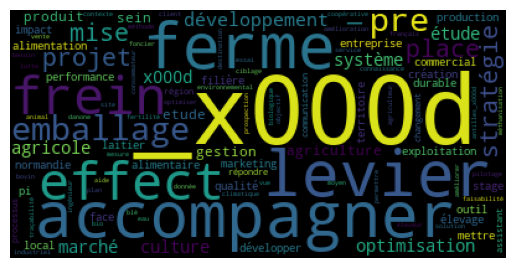

<Figure size 640x480 with 0 Axes>

In [65]:
text = " ".join([(k + " ") for k,v in list_sorted])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()

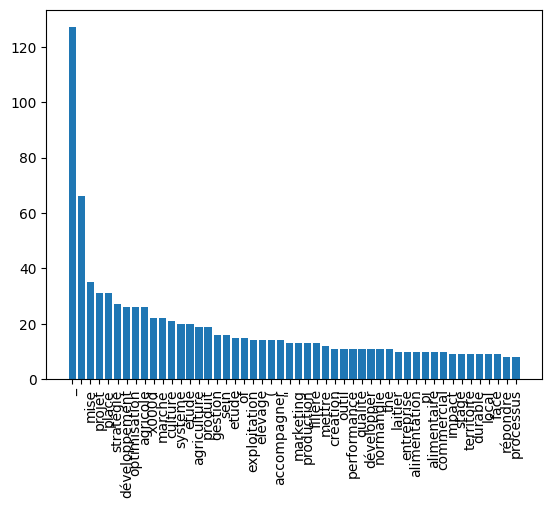

In [66]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20, 10)
#df_words[:50].plot.bar()
ax.bar(df_words.word[:50].tolist(), df_words.freq[:50].tolist())
plt.xticks(rotation = 90)
plt.show()

## Détection des thématiques.

Dans cette section, nous allons mettre en oeuvre l'algorithme LDA pour la détection des thématiques. Celui-ci est fourni par la librairie "Gensim" et nécessite deux éléments en entrée :


*   Un dictionnaire du vocabulaire contenu dans tout  le corpus de textes, indexé par des nombre entier.
*   Le corpus de tous les textes (liste de listes contenant les tokens de chaque texte).

Il faut par ailleurs spécifier à l'lgorithme le nombre de thématiques désiré (num_topics).

In [67]:
dictionary = corpora.Dictionary(token_list)
corpus = [dictionary.doc2bow(text) for text in token_list]

In [68]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes=20)
cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
print(cm.get_coherence())

-13.742553877546499


Il est possible de déterminer le nombre de thématiques d'une manière automatique en maximisant une métrique ("coherence"). Il suffit alors d'itérer l'algorithme LDA sur différents nombre de thématiques (ici de 2 à 9) et de sélectionner ensuite le nombre de thématiques ayant le plus grand score de cohérence alors que la courbe de cohérence est en phase ascendante.

In [69]:
coherence = []
for num in range(2, 10, 1):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num, id2word = dictionary, passes=20)
    cm = CoherenceModel(model = ldamodel, corpus = corpus, coherence = 'u_mass')
    coherence.append(cm.get_coherence())

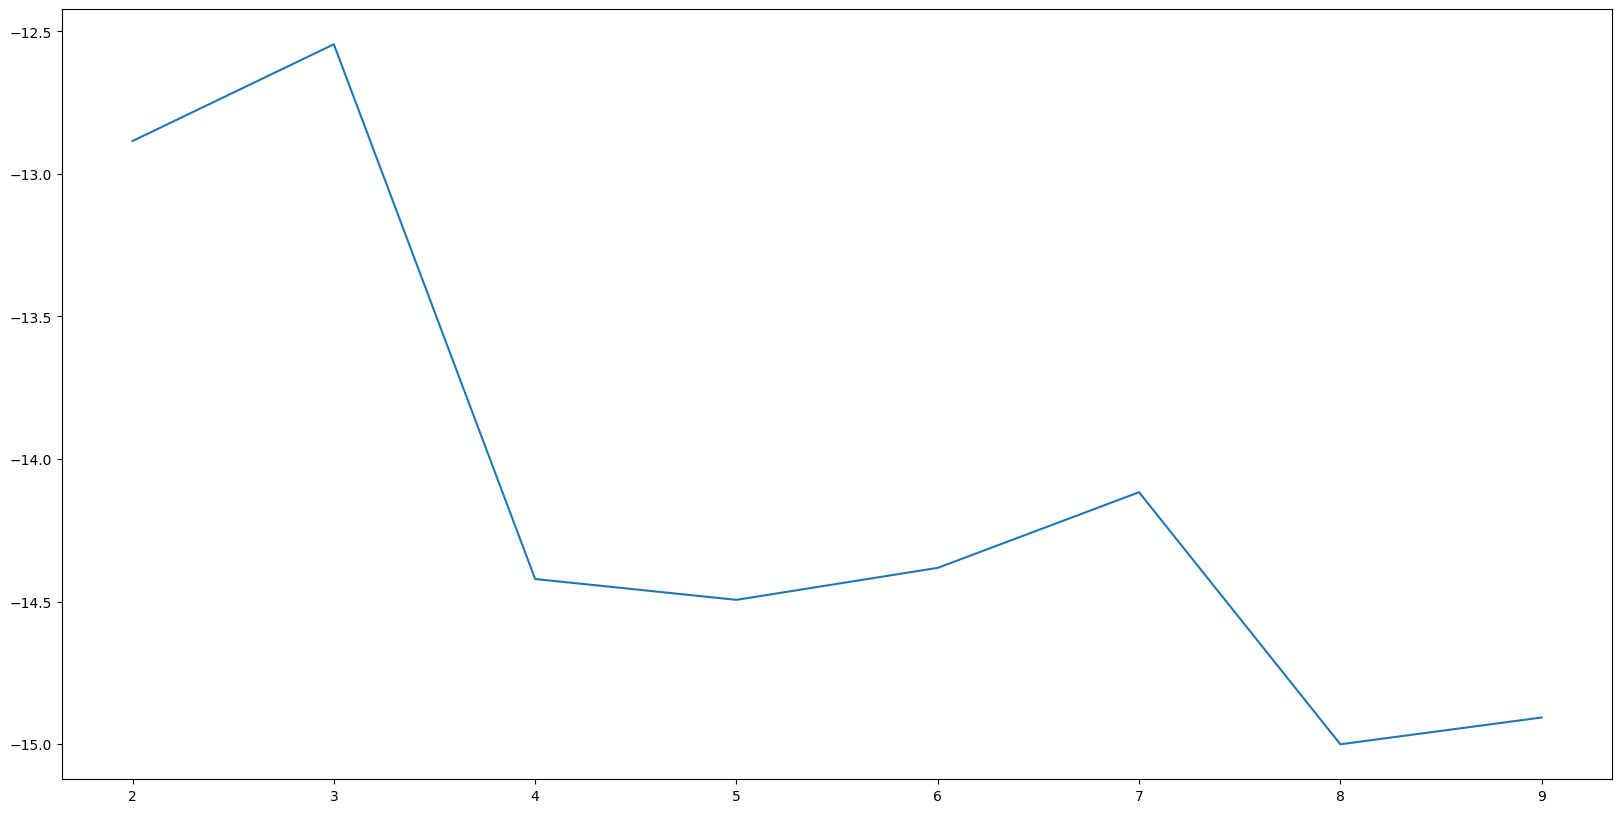

In [70]:
x = range(2, 10, 1)
plt.plot(x, coherence)
plt.show()

On peut ensuite exécuter le LDA pour le nombre de thématiques optimal, déterminé automatiquement ou choisi d'une manière ad hoc.

In [71]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word = dictionary, passes=20)

La librairie "PyLDAvis" permet de visualiser les thématiques ainsi que les mots clés associés à chacune d'elle d'une manière intuitive.

In [72]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary = ldamodel.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.123537 -0.017845       1        1  27.364307
3      0.097394 -0.107682       2        1  26.913125
1     -0.038946 -0.001083       3        1  25.824725
2      0.065089  0.126609       4        1  19.897843, topic_info=            Term       Freq      Total Category  logprob  loglift
269    stratégie  19.000000  19.000000  Default  30.0000  30.0000
92     marketing   9.000000   9.000000  Default  29.0000  29.0000
607        étude  15.000000  15.000000  Default  28.0000  28.0000
57       culture  16.000000  16.000000  Default  27.0000  27.0000
459           of  11.000000  11.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
87     assistant   2.978077   6.469485   Topic4  -5.2742   0.8387
610   commercial   3.156907   7.938263   Topic4  -5.2159   0.6925
49          mise   4.321744  26.372370   Topic4  -4.9018  -0.1941
60             "   2.985661  10.116079   Topic4  -5.2716   0.3943
703  agriculteur   2.949659   6.471641   Topic4  -5.2838   0.8288

[258 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
81        1  0.081848         
81        2  0.306928         
81        3  0.388776         
81        4  0.204619         
60        3  0.691968        "
...     ...       ...      ...
212       4  0.181558  élevage
769       3  0.908964   éolien
811       3  0.681182     état
607       1  0.704840    étude
607       2  0.256305    étude

[336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])